### Pipeline: Segmentation + Time Series Clustering

This notebook contains all the models runed (segmentation + time series clustering models)

Note: The models in this notebook have been runned less times because of time issues.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
from tslearn.utils import to_time_series_dataset

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score as silhouette_time_point
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.metrics import silhouette_samples
from tslearn.metrics import cdist_dtw

from mt3scm import mt3scm_score

from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

In [2]:
ts_data_usa = pd.read_csv('../Data/Clean Data/ts_zdata.csv')
ts_data_usa = ts_data_usa[ts_data_usa.columns[2:]] 
ts_data_china = pd.read_csv('../Data/Clean Data/ts_zdata_china.csv')

In [3]:
ts_data_usa

,report_intensity,reports_dispersion,wind_speed,wind_dir_sin,wind_dir_cos,wind_std_dir,so2_avg,so2_top,h2s_avg,h2s_top
0,-0.157437,-1.578301,-1.252416,0.280321,-0.222816,1.024987,-0.361539,0.000462,-0.559566,-0.410486
1,-0.151564,-1.645146,-1.032301,0.363363,-0.156433,0.510890,-0.122213,0.087651,-0.447187,-0.379545
2,-0.086965,-2.020338,-0.951771,0.351290,-0.164777,0.305617,0.766715,1.003133,0.088776,0.208332
3,-0.116328,-2.001268,-0.884215,0.350520,-0.171512,0.278099,1.832288,1.133916,0.858141,0.486800
4,1.316603,-2.296753,-0.722708,0.562901,-0.265060,-0.260124,2.544570,1.199308,1.299013,0.486800
...,...,...,...,...,...,...,...,...,...,...
10706,-0.357108,0.215788,-0.952442,0.284016,-0.745978,0.359609,-0.783210,-0.773339,-0.680589,-0.719895
10707,-0.357108,0.093599,-0.986443,0.339001,-0.750742,0.309269,-0.817400,-0.871426,-0.697879,-0.781777
10708,-0.409962,0.108148,-0.938349,0.427353,-0.751731,0.048699,-0.817400,-0.871426,-0.697879,-0.781777
10709,-0.509797,-0.236565,-0.958929,0.460793,-0.768472,-0.420013,-0.817400,-0.871426,-0.697879,-0.781777


#### Time point clustering models

In [4]:
def clustering_kmeans(time_series, num_clusters):
    results_s = []
    results_dbi = []
    
    for _ in range(10):
        kmeans = KMeans(n_clusters=num_clusters).fit(time_series)
        labels = kmeans.labels_

        results_s.append(silhouette_time_point(time_series, labels))
        results_dbi.append(mt3scm_score(time_series, labels))

    

    return [f"Silhouette: {np.mean(results_s)} {np.std(results_s)}", f"MT3SCM: {np.mean(results_dbi)} {np.std(results_dbi)}"] 

print("k-means Smell PGH:")
print(clustering_kmeans(ts_data_usa, 4))

def clustering_spectral(time_series):
    results_s = []
    results_dbi = []
    
    for _ in range(5):
        dbscan = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(time_series)
        labels = dbscan.labels_
        
        results_s.append(silhouette_time_point(time_series, labels))
        results_dbi.append(mt3scm_score(time_series, labels))

    return [f"Silhouette: {np.mean(results_s)} {np.std(results_s)}", f"mt3scm_score: {np.mean(results_dbi)} {np.std(results_dbi)}" ] 


print("Spectral Clustering Smell PGH:")
print(clustering_spectral(ts_data_china))

k-means Smell PGH:
['Silhouette: 0.23901127627389665 4.832553657791868e-05', 'MT3SCM: 0.08702719597775818 0.00010204319221896084']
Spectral Clustering Smell PGH:
['Silhouette: 0.2984827366528353 0.0', 'mt3scm_score: 0.08763176659214555 0.0']


#### Segmentation methods

In [14]:
def segmentation_sliding_window(time_series, window_length, window_overlap):
    windowed_data = []
    for i in range(0, len(time_series) - window_length + 1, window_overlap):
        window = time_series[i:i+window_length]
        windowed_data.append(window)
    
    return windowed_data

def get_breaking_points_bottom_up(df, n_bkps):

    signal = []

    for column in df.columns:
        signal += [df[column].to_numpy()]
    
    signal = np.array(signal).transpose()
   
    model = rpt.BottomUp(model="l2").fit(signal)
    bkps = model.predict(n_bkps=n_bkps)
    return bkps

def segmentate_timeseries(time_series, breaking_points):
    list_segments = []
    init = 0
    for bkpt in breaking_points:
        ts = time_series.iloc[init:bkpt]
        list_segments.append(ts)
        init = bkpt
    
    return list_segments

def segmentate_timeseries_column(time_series, breaking_points, column):
    """Segmentaties a time series but only returns one columnn"""
    list_segments = []
    init = 0
    for bkpt in breaking_points:
        ts = time_series.iloc[init:bkpt]
        list_segments.append(ts[column])
        init = bkpt
    
    return list_segments


def standardize_time_series(time_series_data, target_length):
    "Standarise multiple segments to the same target length"
    standardized_data = []

    for time_series in time_series_data:
        # Calculate the original length and create an array of corresponding indices
        original_length = len(time_series)
        original_indices = np.arange(original_length)
        # Create interpolation function based on the original data
        interpolation_function = interp1d(original_indices, time_series)
        # Generate new indices for the target length
        target_indices = np.linspace(0, original_length - 1, target_length)
        # Interpolate the time series to the target length
        interpolated_time_series = interpolation_function(target_indices)
        # Append the interpolated time series to the list
        standardized_data.append(interpolated_time_series)

    return standardized_data

#### MT3SCM evaluation

Sometimes it requires to rearange the predicted labels as MT3SCM doesn't allow overlapped segments

In [6]:
def ts_silhouette_samples(X, labels):
    metric_params_ = {}
    sklearn_x = cdist_dtw(X, verbose=0, **metric_params_)
    silhouette_vals = silhouette_samples(sklearn_x, labels, metric="precomputed")
    
    return silhouette_vals

def mt3scm_score_overlapping(timeseries, subsequences, labels, width_segment, overlap_frac):
    
    overlap_w  = int(overlap_frac * width_segment)
    "For overlapping subsequences in a timeseries"
    silhouette_scores = ts_silhouette_samples(subsequences, labels)

    new_labels = []
    new_labels += [labels[0]]*(width_segment-overlap_w)
    for i in range(len(labels)-1):
        if silhouette_scores[i+1] >= silhouette_scores[i]:
            new_labels += [labels[i+1]]*overlap_w
        else:
            new_labels += [labels[i]]*overlap_w
        
        new_labels += [labels[i+1]]*(width_segment - 2*overlap_w)
    new_labels += [labels[-1]]*(width_segment-overlap_w)

    score = mt3scm_score(timeseries.iloc[:len(new_labels)], new_labels)

    return score

def mt3scm_score_bottomup(timeseries, subsequences, labels):
    
    new_labels = []
    for subsequence, label in zip(subsequences, labels):
        new_labels += [label]*len(subsequence)

    score = mt3scm_score(timeseries.iloc[:len(new_labels)], new_labels)

    return score

#### TimeSeriesKMeans + Bottom-up Segmentation

Parameters:

* Smell PGH    - Bottom-up segmentation: 800
* Beijing data - Bottom-up segmentation: 450

In [7]:
def subseq_clustering_kmeans(ts_data, n_seq, n_clusters):

    n_seg = n_seq
    n_clusters = n_clusters
    
    bkpts = get_breaking_points_bottom_up(ts_data, n_seg)
    multi_ts = segmentate_timeseries(ts_data, bkpts)

    silhouette_v = []
    mt3scm_v = []

    X_train_best, y_pred_best = None, None
    best_score = -1

    for _ in range(1):
        X_train = to_time_series_dataset(multi_ts)
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=4)
        y_pred = km.fit_predict(X_train)

        score1 = silhouette_score(X_train, y_pred, metric="dtw", n_jobs=4)
        silhouette_v.append(score1)
        score2 = mt3scm_score_bottomup(ts_data, multi_ts, y_pred)
        mt3scm_v.append(score2)

        if score1 >= best_score:
            X_train_best, y_pred_best = X_train, y_pred
            best_score = score1
    
    return [f"Silhouette: {np.mean(silhouette_v)} {np.std(silhouette_v)}", f"mt3scm_score: {np.mean(mt3scm_v)} {np.std(mt3scm_v)}"], X_train_best, y_pred_best


score, X_train_usa, y_pred_usa = subseq_clustering_kmeans(ts_data_usa, 800, 4)
score


['Silhouette: 0.15226409456245096 0.0',
 'mt3scm_score: 0.07009625697504757 0.0']

#### TimeSeriesKMeans + Sliding Window segmentation

Parameters:

* Smell PGH: Segment size: 18, Segment overlap: 0.275
* Beijing data: Segment size: 100, Segment overlap: 0.275

In [9]:
def subseq_clustering_sliding(ts_data, n_clusters, width_segment, overlap_frac):
    
    overlap_segment = width_segment - int(overlap_frac * width_segment)
    multi_ts = segmentation_sliding_window(ts_data, width_segment, overlap_segment)
    
    silhou_values = []
    mt3scm_values = []

    for _ in range(4):
        X_train = to_time_series_dataset(multi_ts)
        km = TimeSeriesKMeans(n_clusters=n_clusters)
        y_pred = km.fit_predict(X_train)
        score1 = silhouette_score(X_train, y_pred, metric="dtw", n_jobs=4)
        score2 = mt3scm_score_overlapping(ts_data, X_train, y_pred, width_segment, overlap_frac)
        silhou_values.append(score1)
        mt3scm_values.append(score2)

    return [f"Silhouette: {np.mean(silhou_values)} {np.std(silhou_values)}", f"mt3scm_score: {np.mean(mt3scm_values)} {np.std(mt3scm_values)}"]

score =  subseq_clustering_sliding(ts_data_usa, 4, 18, 0.275)
score

['Silhouette: 0.10626160567621126 0.0022962383556305544',
 'mt3scm_score: 0.0578756057281629 0.004888728160609223']

#### k-Shape + Sliding Window segmentation

Parameters:

* Smell PGH: Segment size: 18, Segment overlap: 0.275
* Beijing data: Segment size: 100, Segment overlap: 0.275

In [12]:
def subseq_clustering_kshape(ts_data, width_segment, overlap_frac, n_clusterss):

    overlap_segment = width_segment - int(overlap_frac * width_segment)
   
    multi_ts = segmentation_sliding_window(ts_data, width_segment, overlap_segment)
    
    X_train = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(multi_ts))

    values = []

    for _ in range(8):
        km = KShape(n_clusters=4)
        y_pred = km.fit_predict(X_train)
    
        score = silhouette_score(X_train, y_pred, metric='dtw', n_jobs=4)
        score = mt3scm_score_overlapping(ts_data, X_train, y_pred, width_segment, overlap_frac)
        values.append(score)
    

    return np.mean(values), np.std(values)

subseq_clustering_kshape(ts_data_usa, 18, 0.275, 4)

(-0.023940851015738, 0.006573902947733914)

#### Interpolating Bottom Up to be fixed-length and use fixed-lenth clustering methods

In [15]:
def standardize_bottom_up_time_series(time_series_data, target_length):
    standardized_data = []

    for multiv_time_series in time_series_data:
        df_copy = multiv_time_series.copy()
        new_df  = pd.DataFrame(index=range(target_length))
        arr = standardize_time_series(df_copy.to_numpy().T, target_length)
        for i, column in enumerate(multiv_time_series.columns):
            new_df[column] = arr[i]
        standardized_data.append(new_df)
            

    return standardized_data

In [34]:
def bottom_up_fixed_length(ts_data, n_bkps, fixed_length):
    bkpts =  get_breaking_points_bottom_up(ts_data, n_bkps)
    multi_ts = segmentate_timeseries(ts_data, bkpts)
    std_multi_ts = standardize_bottom_up_time_series(multi_ts, fixed_length)
    return std_multi_ts

def KShape_bottom_up(ts_data, n_bkps, fixed_length):

    bkpts = get_breaking_points_bottom_up(ts_data, n_bkps)
    multi_ts_original = segmentate_timeseries(ts_data, bkpts)

    multi_ts = bottom_up_fixed_length(ts_data, n_bkps, fixed_length)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(multi_ts))

    values_silhouette = []
    values_mt3scm = []

    for _ in range(7):
        km = KShape(n_clusters=4)
        y_pred = km.fit_predict(X_train)

        score1 = silhouette_score(X_train, y_pred, metric='dtw', n_jobs=4)
        #mt3scm_score_bottomup(ts_data_usa, multi_ts, y_pred_usa)
        score2 = mt3scm_score_bottomup(ts_data, multi_ts_original, y_pred) #(ts_data, X_train, y_pred, fixed_length, 0)
        values_silhouette.append(score1)
        values_mt3scm.append(score2)
    

    return [f"Silhouette: {np.mean(values_silhouette)} {np.std(values_silhouette)}", f"mt3scm_score: {np.mean(values_mt3scm)} {np.std(values_mt3scm)}"]


KShape_bottom_up(ts_data_usa, 800, 15)

['Silhouette: 0.023636135170192328 0.005536088586740757',
 'mt3scm_score: -0.03175548774655875 0.012787705925908617']

### Evaluation MT3SCM DTC Results

In [28]:
width_segment = 100
overlap_frac = 0.275

y_pred_china = np.genfromtxt('Labels DTC/y_pred_china_dtc.csv', delimiter=',')

overlap_segment = width_segment - int(overlap_frac * width_segment)
multi_ts = segmentation_sliding_window(ts_data_china, width_segment, overlap_segment)    
X_train = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(multi_ts))
mt3scm_score_overlapping(ts_data_china, X_train, y_pred_china, width_segment, overlap_frac)

-0.033504483832390214

In [29]:
width_segment = 18
overlap_frac = 0.275

y_pred_usa = np.genfromtxt('Labels DTC/y_pred_usa_dtc.csv', delimiter=',')

overlap_segment = width_segment - int(overlap_frac * width_segment)
multi_ts = segmentation_sliding_window(ts_data_usa, width_segment, overlap_segment)    
X_train = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(multi_ts))
mt3scm_score_overlapping(ts_data_usa, X_train, y_pred_usa, width_segment, overlap_frac)

-0.028289518780258028

##### Evaluation for fixed-length bottom up with DTC outcome

In [32]:
n_bkps = 800
breaking_points = get_breaking_points_bottom_up(ts_data_usa, n_bkps)

y_pred_usa = np.genfromtxt('Labels DTC/y_pred_usa_fixed_dtc.csv', delimiter=',')


multi_ts = segmentate_timeseries(ts_data_usa, breaking_points)    
mt3scm_score_bottomup(ts_data_usa, multi_ts, y_pred_usa)

-0.032366875507206634

#### Silhouette score visualisation

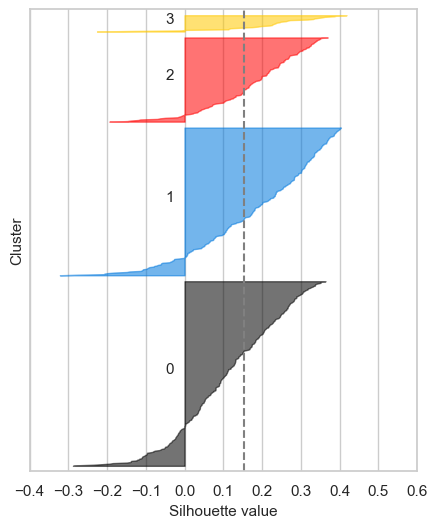

In [20]:
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import seaborn as sns



def compute_ts_silhouette(X, labels):
    metric_params_ = {}
    sklearn_x = cdist_dtw(X, verbose=0, **metric_params_)
    silhouette_vals = silhouette_samples(sklearn_x, labels, metric="precomputed")
    
    return silhouette_vals


def silhouette_plot(X, cluster_labels):

    n_clusters = np.max(cluster_labels) + 1
    plt.rcParams.update({'font.size': 11})
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(5, 6)
    ax1.set_xlim([-0.1, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, cluster_labels, metric="dtw", n_jobs=4)
    sample_silhouette_values = compute_ts_silhouette(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        color = "red" if i == 2 else color
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.55,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Silhouette value", fontsize=11)
    ax1.set_ylabel("Cluster", fontsize=11)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="grey", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-.4, -.3, -.2, -.1,  0, .1, .2, .3, .4, .5, .6])
    
    sns.set(style="whitegrid",palette="pastel")

    plt.show()


silhouette_plot(X_train_usa, y_pred_usa)

#### Visualization clusters

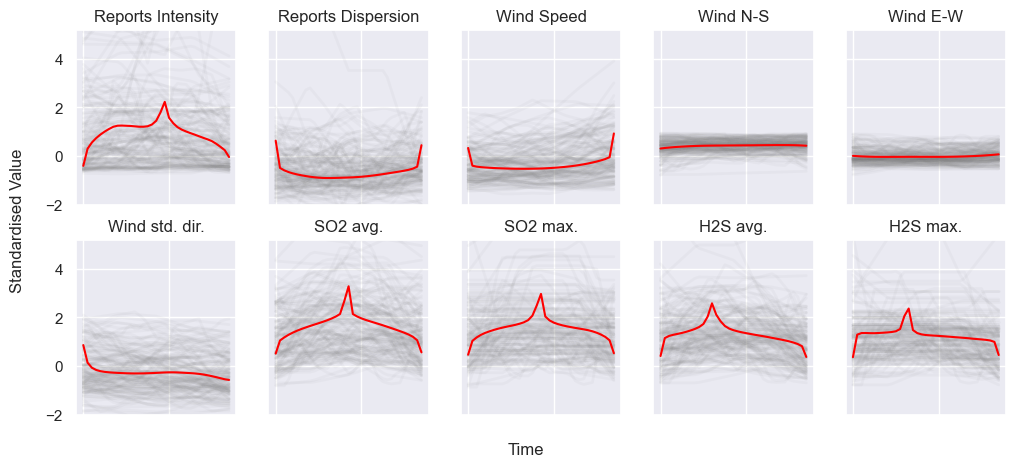

In [24]:
import random
from tslearn.barycenters import softdtw_barycenter

def get_best_cluster(time_series_data, sample_silhouette_values, cluster_labels):
    best_cluster, silhouette_score = -1, -1
    for i in range(np.max(cluster_labels) + 1):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        cluster_silhouette_score = np.mean(ith_cluster_silhouette_values)
        if cluster_silhouette_score > silhouette_score:
            silhouette_score = cluster_silhouette_score
            best_cluster = i
    return best_cluster

def get_best_clustered_samples(silhouette_values, percentage=1):
    percentile_pos = int(len(silhouette_values)*(1 - percentage))
    percentile_value = np.sort(silhouette_values)[percentile_pos]
    return silhouette_values > percentile_value

def create_visualizable_ts(X_train, y_pred, cluster_i):
    time_series_cluster = X_train[y_pred == cluster_i]
    if False: #75% best clustered samples
        silhouette_samples = compute_ts_silhouette(X_train, y_pred)[y_pred == cluster_i]
        best_clustered_samples = get_best_clustered_samples(silhouette_samples)
        time_series_cluster = time_series_cluster[best_clustered_samples]
    input_array = []
    for subsequence in time_series_cluster:
        segment = []
        for datapoint in subsequence:
            if not np.isnan(datapoint[0]):
                segment.append(datapoint)
        input_array.append(segment)

    return input_array

def visualise_time_series_clustering(time_series_data, labels, cluster_index, country):
    """ Time series data of the selected cluster"""
    time_series_data = create_visualizable_ts(time_series_data, labels, cluster_index)
    if country == "USA":
        column_names = ["Reports Intensity", "Reports Dispersion", "Wind Speed", "Wind N-S", "Wind E-W", "Wind std. dir.", "SO2 avg.", "SO2 max.", "H2S avg.", "H2S max."]
        nrows, ncols, = 2, 5
    if country == "CHINA":
        column_names = ["PM2.5", "PM10", "SO2", "CO", "O3", "TEMP", "PRES", "DEWP"]
        nrows, ncols, = 2, 4
    sns.set_theme()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 5))
    for pos in range (nrows * ncols):
        i, j = pos // ncols, pos % ncols
        #median = int(np.average([len(time_series) for time_series in time_series_data]))
        median = 35
        #print(median)
        series_collection = []
        for time_series in time_series_data:
            series = [x[pos] for x in time_series]
            series = standardize_time_series([series], median)[0]
            ax[i][j].plot(series, color="grey", alpha=0.05, linewidth=2)
            series_collection.append(series)
        
        ax[i][j].plot(softdtw_barycenter(series_collection, max_iter=5), color="red") 
        ax[i][j].set_xticklabels([])
        ax[i][j].set_title(column_names[pos])
        ax[i][j].set_ylim(-2, 5.2)

    fig.text(0.07, 0.5, 'Standardised Value', va='center', rotation='vertical')
    fig.text(0.5, 0.04, 'Time', ha='center', va='center')
    plt.show()

#get_best_cluster(X_train, compute_ts_silhouette(X_train, y_pred), y_pred)
visualise_time_series_clustering(X_train_usa, y_pred_usa, 2, "USA")       
#best cluster == 1


#### Average statistics per cluster

In [26]:
from scipy.stats import f_oneway

def pvalue_anova(dataframe, feature):
    num_clusters = dataframe['cluster'].max() + 1
    samples = []
    for cluster in range(num_clusters):
        filtered = dataframe[dataframe['cluster'] == cluster][feature]
        #print(filtered.mean())
        samples.append(filtered.to_numpy())
    F, p = f_oneway(*samples)
    #F, p = kruskal(*samples)
    return p

def ts_labels_2_dflabels(subsequences, labels):
    subsequences_clean = []
    for subsequence in subsequences:
        segment = []
        for datapoint in subsequence:
            if not np.isnan(datapoint[0]):
                segment.append(datapoint)
        subsequences_clean.append(segment)

    new_labels = []
    for subsequence, label in zip(subsequences_clean, labels):
        new_labels += [label]*len(subsequence)
    return new_labels

df_labels = ts_labels_2_dflabels(X_train_usa, y_pred_usa)

df_data = ts_data_usa.copy()
df_data['cluster'] = df_labels

avg_stats_table = df_data.groupby('cluster').mean().sort_values('cluster').transpose().reset_index()
avg_stats_table['pvalue'] = avg_stats_table['index'].apply(lambda feature: pvalue_anova(df_data, feature))
avg_stats_table

cluster,index,0,1,2,3,pvalue
0,report_intensity,-0.062481,-0.318431,0.768647,2.515359,0.000000e+00
1,reports_dispersion,0.044027,0.155017,-0.505094,-0.759402,1.609070e-115
2,wind_speed,-0.435652,0.874991,-0.270522,-0.478027,0.000000e+00
3,wind_dir_sin,0.066019,0.129178,0.395663,0.349053,5.055941e-134
4,wind_dir_cos,-0.003767,0.429743,0.004348,-0.013596,0.000000e+00
5,wind_std_dir,0.525082,-0.832454,-0.147927,-0.233259,0.000000e+00
6,so2_avg,-0.231266,-0.291041,1.363981,3.221229,0.000000e+00
7,so2_top,-0.212286,-0.271216,1.307468,2.648056,0.000000e+00
8,h2s_avg,-0.234623,-0.282383,1.216893,4.156692,0.000000e+00
9,h2s_top,-0.195893,-0.296753,1.147485,3.621698,0.000000e+00
